In [3]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from m2bk import *
import cv2
import importlib

%load_ext autoreload
%autoreload 2

np.random.seed(1)
np.set_printoptions(threshold=np.inf, linewidth=np.nan)
dataset_handler = DatasetHandler(100)


In [4]:
def sobel_filter(image):
    # Check if image is grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    

    # Calculate the gradient in the X direction
    sobelx = cv2.Sobel(src=image, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=5)
    # Calculate the gradient in the Y direction
    sobely = cv2.Sobel(src=image, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=5)
    
    # Calculate the magnitude of the gradient
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)

    # Normalise manually to range 255
    gradient_magnitude = (gradient_magnitude - np.min(gradient_magnitude)) / (np.max(gradient_magnitude) - np.min(gradient_magnitude)) * 255
    
    # Convert to an unsigned 8-bit type
    edges = np.uint8(gradient_magnitude)
    
    # Increase contrast using histogram equalization
    contrast_enhanced_edges = cv2.equalizeHist(np.uint8(edges))

    # apply a blur filter
    contrast_enhanced_edges = cv2.GaussianBlur(contrast_enhanced_edges, (7, 7), 100)
    
    # set to two tone colour
    ret, contrast_enhanced_edges = cv2.threshold(contrast_enhanced_edges, 180, 255, cv2.THRESH_BINARY)
    contrast_enhanced_edges = cv2.GaussianBlur(contrast_enhanced_edges, (7, 7), 100)
    ret, contrast_enhanced_edges = cv2.threshold(contrast_enhanced_edges, 150, 255, cv2.THRESH_BINARY)


    
    return contrast_enhanced_edges

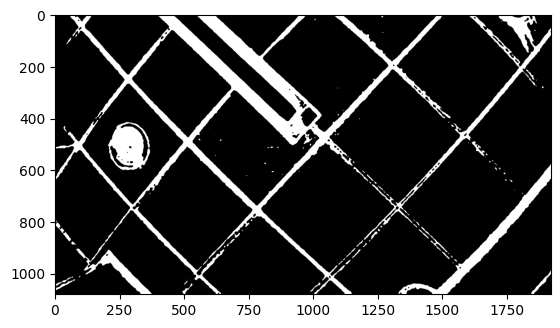

In [5]:
# Process the images to black and white an use canny edge detection to find squares

def sharpen(image):
    # sharpen the image
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1, 0]])
    image_sharpened = cv2.filter2D(image, -1, kernel)

    # set image to greyscale uint8
    image_sharpened = cv2.cvtColor(image_sharpened, cv2.COLOR_BGR2GRAY)

    #increase contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image_sharpened = clahe.apply(image_sharpened)

    
    return image_sharpened

images = dataset_handler.images
image = images[0]


image = sobel_filter(image)

# edges = cv2.Canny(sharpened_image, 50, 150, apertureSize=3)

# contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# for cnt in contours:
#     approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)
#     if len(approx) == 4:  # Filter for quadrilaterals, which may represent square tiles
#         cv2.drawContours(image, 0, (0, 255, 0), 5)

plt.imshow(image, cmap='gray')




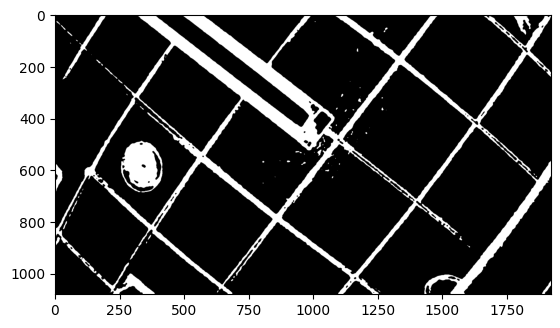

In [6]:
image2 = images[2]

image2 = sobel_filter(image2)

# fix the barrel distortion of the image
# image2 = cv2.undistort(image2, camera_matrix, dist_coeff, None, camera_matrix)

plt.imshow(image2, cmap='gray')

In [7]:
def extract_features(image):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    # sift = cv2.SIFT_create(nfeatures=1000, contrastThreshold=0.04, edgeThreshold=100, )
    # kp, des = sift.detectAndCompute(image, None)

    # extract features in the centre of black squares in the image
    sift = cv2.SIFT_create()
    kp = sift.detect(image, None)
    
    return kp, des

def visualize_features(image, kp):
    """
    Visualize extracted features in the image

    Arguments:
    image -- a grayscale image
    kp -- list of the extracted keypoints

    Returns:
    """
    display = cv2.drawKeypoints(image, kp, None)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.imshow(display)

kp1, des1 = extract_features(image)
kp2, des2 = extract_features(image2)

visualize_features(image, kp1)
visualize_features(image2, kp2)

NameError: name 'des' is not defined

In [8]:
from scipy.spatial import KDTree
from scipy.optimize import least_squares

def cost_function(params, points1, points2):
    """
    Calculate the sum of squared distances between points in 'points1' and their nearest neighbors in 'points2'
    after applying the transformation defined by 'params'.
    """
    # Extract rotation and translation from params
    # For simplicity, consider rotation around the z-axis and 2D translation
    angle = params[0]
    tx, ty = params[1], params[2]
    
    # Create transformation matrix
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    transformation_matrix = np.array([
        [cos_angle, -sin_angle, tx],
        [sin_angle, cos_angle, ty],
        [0, 0, 1]
    ])
    
    # Apply transformation
    transformed_points1 = np.dot(transformation_matrix[:2, :2], points1.T).T + transformation_matrix[:2, 2]
    
    # Build a KD-Tree for efficient nearest neighbor search
    tree = KDTree(points2)
    
    # Find nearest neighbors and calculate distances
    distances, _ = tree.query(transformed_points1, k=1)
    
    # Return squared distances as the cost
    return distances**2

# Example usage:
# Assuming points1 and points2 are your point sets as Nx2 numpy arrays

# Initial guess for parameters (angle, tx, ty)
initial_guess = [0, 0, 0]
points1 = np.array(kp1)
points2 = np.array(kp2)

# Perform the optimization
result = least_squares(cost_function, initial_guess, args=(points1, points2))






NameError: name 'kp1' is not defined

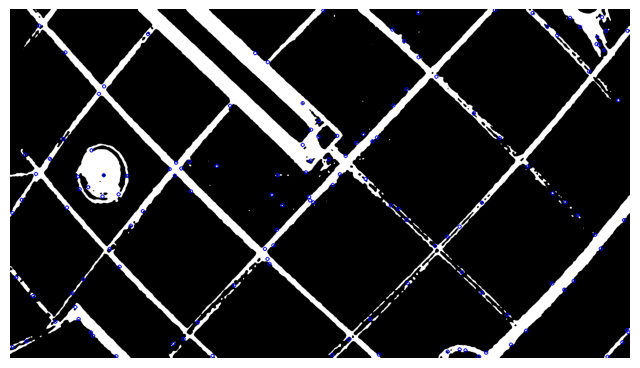

In [12]:
def detect_harris_corners(image, min_distance=200, quality_level=1, blockSize=20, ksize=9, k=0.04):
    """
    Detect corners in an image using the Harris Corner Detection method.

    Parameters:
    - image_path: Path to the image file.
    - min_distance: Minimum possible Euclidean distance between the returned corners.
    - quality_level: Parameter characterizing the minimal accepted quality of image corners.
    - blockSize: Size of an average block for computing a derivative covariation matrix over each pixel neighborhood.
    - ksize: Aperture parameter of the Sobel derivative used.
    - k: Harris detector free parameter in the equation.

    Returns:
    - corners: Coordinates of detected corners.
    - image_with_corners: The original image with detected corners drawn on it.
    """

    # Detecting corners
    dst = cv2.cornerHarris(np.float32(image), blockSize, ksize, k)
    
    # Dilate corner image to enhance corner points
    dst = cv2.dilate(dst, None)
    
    # Threshold for an optimal value, marking the corners in the original image
    ret, dst = cv2.threshold(dst, 0.04 * dst.max(), 255, 0)
    dst = np.uint8(dst)
    
    # Find centroids of corners
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    
    # Define criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(image, np.float32(centroids), (5, 5), (-1, -1), criteria)
    
    # Create an image to draw the corners
    image_with_corners = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    for i in range(1, len(corners)):
        # Draw corners
        cv2.circle(image_with_corners, (int(corners[i, 0]), int(corners[i, 1])), 5, (0, 0, 255), 2)

    return corners, image_with_corners

corners, image_with_corners = detect_harris_corners(image)

# Display the image with detected corners
if corners is not None:
    plt.figure(figsize=(8, 6), dpi=100)
    plt.imshow(image_with_corners)
    plt.axis('off')
    plt.show()    

[[[457   0]]

 [[457   1]]

 [[466  10]]

 [[467  10]]

 [[469  12]]

 [[469  13]]

 [[472  16]]

 [[473  16]]

 [[491  34]]

 [[492  34]]

 [[512  54]]

 [[513  54]]

 [[530  71]]

 [[531  71]]

 [[549  89]]

 [[550  89]]

 [[566 105]]

 [[567 105]]

 [[573 111]]

 [[574 111]]

 [[581 118]]

 [[581 119]]

 [[584 122]]

 [[585 122]]

 [[601 138]]

 [[602 138]]

 [[616 152]]

 [[617 152]]

 [[634 169]]

 [[635 169]]

 [[640 174]]

 [[640 175]]

 [[643 178]]

 [[644 178]]

 [[656 190]]

 [[657 190]]

 [[661 194]]

 [[661 195]]

 [[666 200]]

 [[667 200]]

 [[676 209]]

 [[677 209]]

 [[680 212]]

 [[680 213]]

 [[683 216]]

 [[684 216]]

 [[696 228]]

 [[697 228]]

 [[715 246]]

 [[716 246]]

 [[736 266]]

 [[737 266]]

 [[763 292]]

 [[764 292]]

 [[778 306]]

 [[779 306]]

 [[786 313]]

 [[787 313]]

 [[789 315]]

 [[789 316]]

 [[795 322]]

 [[796 322]]

 [[810 336]]

 [[811 336]]

 [[812 337]]

 [[812 338]]

 [[817 343]]

 [[818 343]]

 [[829 354]]

 [[830 354]]

 [[833 357]]

 [[833

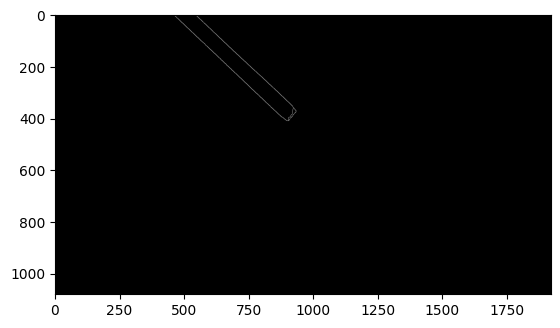

In [58]:
image = dataset_handler.images[0]

def find_lights(image):
    image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    contrast_enhanced_edges = cv2.GaussianBlur(image, (7, 7), 100)
    ret, contrast_enhanced_edges = cv2.threshold(contrast_enhanced_edges, 252, 255, cv2.THRESH_BINARY)


    return(contrast_enhanced_edges)

image = find_lights(image)


# invert image and plot
image = cv2.bitwise_not(image)


#convert to uint8 from black and white
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gray = cv2.bilateralFilter(image, 11, 17, 17)

# find lines betwween black and white
edge = cv2.Canny(gray, 20, 200, L2gradient=True)

cnts, _ = cv2.findContours(edge.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


cnt = sorted(cnts, key=cv2.contourArea, reverse=True)[0]

print(cnt)

# create a mask for the image
mask = np.zeros(image.shape, dtype=np.uint8)
#img = cv2.drawContours(mask, [cnt], -1, 255, -1)

img2 = cv2.fillPoly(mask, pts=[cnt], color=(255, 255, 255))

plt.imshow(img2, cmap='gray')

    


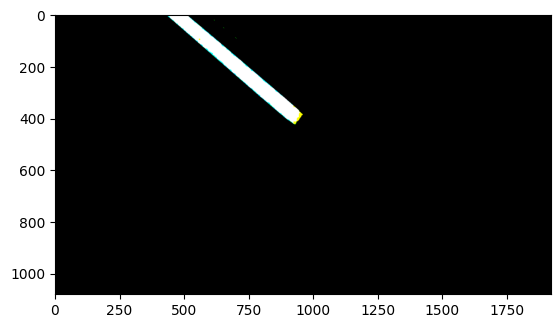

In [26]:
image2 = dataset_handler.images[1]

image2 = find_lights(image2)

plt.imshow(image2, cmap='gray')

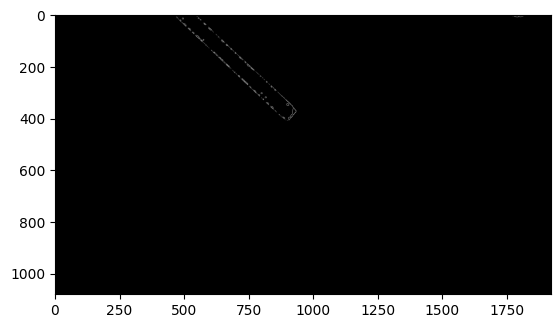

In [40]:
# function to extract the edges of a two tone image
def extract_edges(image):
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    return edges

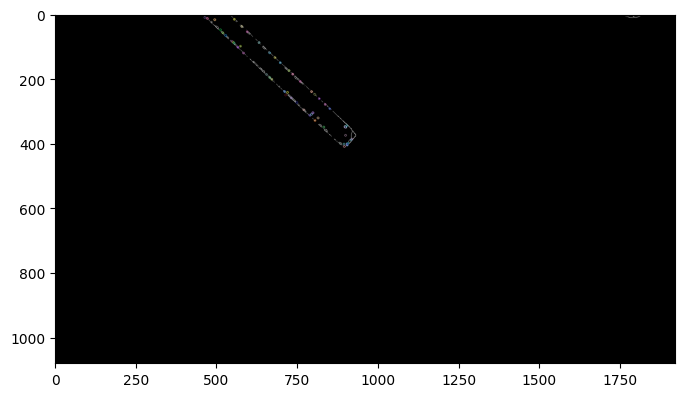

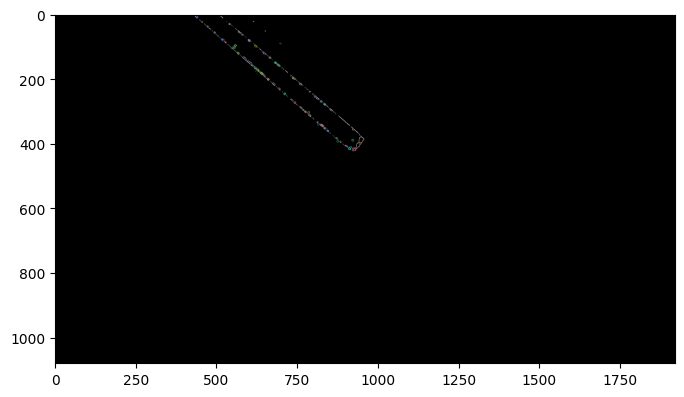